# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [8]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import seaborn as sns
import pandas as pd

import brfss

import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [9]:
df = brfss.ReadBrfss(nrows=None)

The following function selects a random subset of a `DataFrame`.

In [10]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [11]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

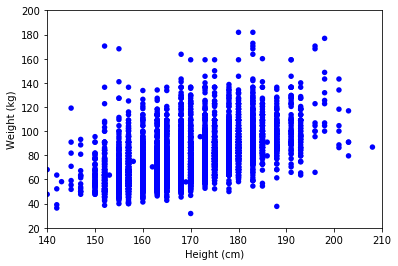

In [12]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [13]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4.

In [14]:
heights = Jitter(heights, 1.4)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

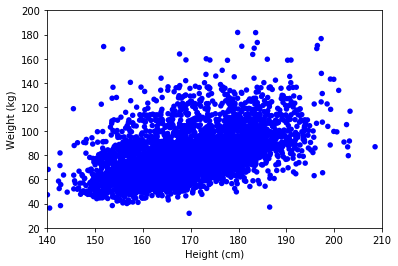

In [15]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

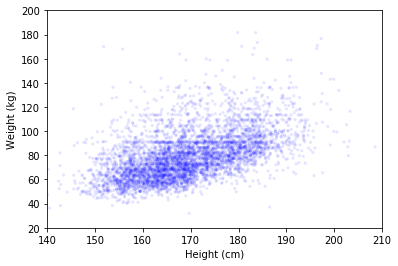

In [16]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

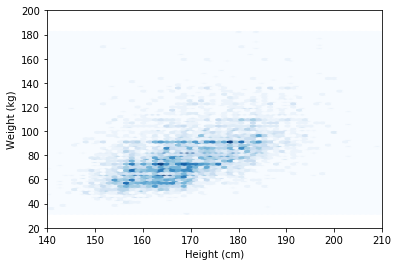

In [17]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

In [18]:
# Solution goes here
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


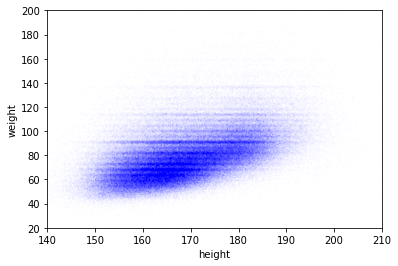

In [19]:
heights = Jitter(df.htm3, 2.8)
weights = Jitter(df.wtkg2, 1.0)
thinkplot.Scatter(heights, weights, alpha=0.01, s=2)
thinkplot.Config(xlabel='height',
                 ylabel='weight',
                 axis=[140, 210, 20, 200],
                 legend=False)

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [20]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [21]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

Here are the number of respondents in each group:

In [22]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [23]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

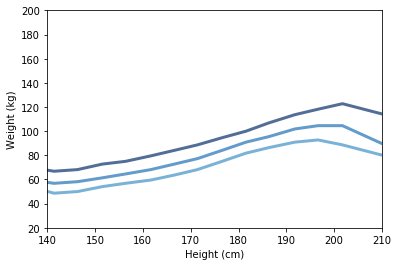

In [24]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

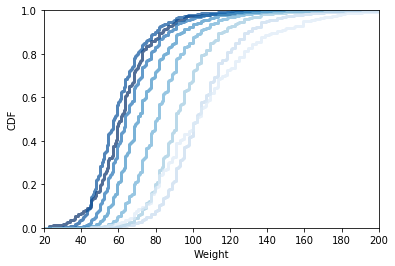

In [25]:
# Solution goes here
bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]
thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='Weight',
                 ylabel='CDF',
                 axis=[20, 200, 0, 1],
                 legend=False)

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [26]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [27]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.3329085769776

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [28]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [29]:
Corr(heights, weights)

0.5087364789734607

NumPy provides a function that computes correlations, too:

In [30]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [31]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [32]:
SpearmanCorr(heights, weights)

0.5405846262320476

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [33]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [34]:
SpearmanCorr(heights, weights)

0.5405846262320491

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [35]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983452

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [36]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [37]:
# Solution goes here
ages = live.agepreg
weights = live.totalwgt_lb
print('Corr', Corr(ages, weights))
print('SpearmanCorr', SpearmanCorr(ages, weights))

Corr 0.06883397035410908
SpearmanCorr 0.09461004109658226


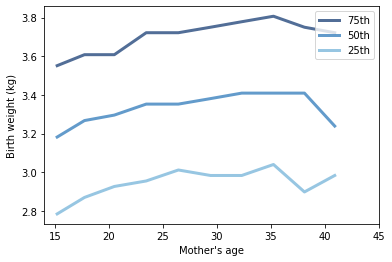

In [38]:
# Solution goes here
def BinnedPercentiles(df):
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)
    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        arr = weights
        weights = []
        for weight in arr:
            weights.append(weight/2.2)
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(xlabel="Mother's age",
                     ylabel='Birth weight (kg)',
                     xlim=[14, 45], legend=True)
    
BinnedPercentiles(live)

Making a function 'ScatterPlot' that shows a relationship between the variables(ages and weights), but
   it is difficult to see it clearly.

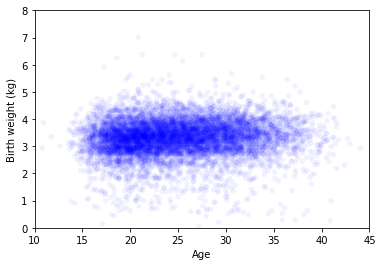

In [39]:
# Solution goes here
def ScatterPlot(ages, weights, alpha):
    thinkplot.Scatter(ages, weights, alpha=alpha)
    thinkplot.Config(xlabel='Age',
                     ylabel='Birth weight (kg)',
                     xlim=[10, 45],
                     ylim=[0, 8],
                     legend=False)
    
ScatterPlot(ages, weights/2.2, alpha=0.05)

Importing my Steam dataset and clearing it from unnecessary entries:

In [40]:
data = pd.read_csv('steam.csv')
data['rating_pct'] = np.round((100 * data.positive_ratings) / (data.positive_ratings + data.negative_ratings), 2)
data = data[(data.rating_pct>0) & (data.rating_pct<100)]
data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,rating_pct
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,97.39
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,83.98
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,89.56
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,82.66
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,94.80


In [41]:
# installs = []
# new_data = list(my_data.Installs)
# for i in new_data:
#     i = i.replace(',', '')
#     i = i.replace('+', '')
#     if i != 'Free':
#         installs.append(float(i))
#     if len(installs) == 9366:
#         break
# ratings = list(map(float, list(my_data.Rating.dropna())))
# rat = ratings
# ratings = []
# for i in rat:
#     if i <= 5.0:
#         ratings.append(i)

Displaying Scatter graph between ratings and the prices of paid-for applications:

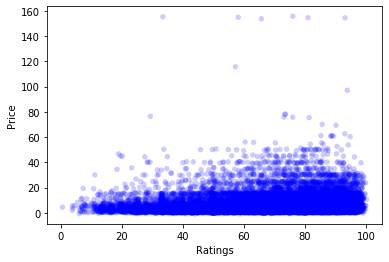

In [42]:
paid = data[data.price>0]
ratings = Jitter(pd.Series(paid.rating_pct))
prices = Jitter(pd.Series(paid.price))
thinkplot.Scatter(ratings, prices)
thinkplot.Config(xlabel='Ratings',
                 ylabel='Price')

Comparing Pearson's and Spearman's correlations. Pearson's is around 0.13, Spearman's is around 0.2. The difference between them suggests some influence of a non-linear relationship.

In [43]:
print("Pearson's Correlation", Corr(ratings, prices))
print("Spearman's Correlation", SpearmanCorr(ratings, prices))

Pearson's Correlation 0.13625671392100666
Spearman's Correlation 0.20083053141728044


Here we re-define the 'BinnedPercentiles' function for our dataset.

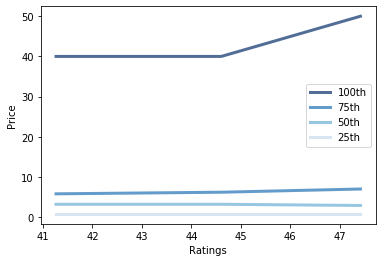

In [48]:
def BinnedPercentiles(df):
    bins = np.arange(40, 50, 3)
    indices = np.digitize(df.rating_pct, bins)
    groups = df.groupby(indices)
    ratings = [group.rating_pct.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.price) for i, group in groups][1:-1]
    thinkplot.PrePlot(4)
    for percent in [100, 75, 50, 25]:
        prices = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ratings, prices, label=label)

    thinkplot.Config(xlabel="Ratings",
                     ylabel="Price",
                     legend=True)
BinnedPercentiles(data)

Making a function 'ScatterPlot' that shows a relationship between the ratings and prices:

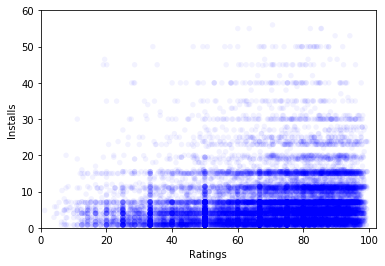

In [52]:
def ScatterPlot(ratings, prices, alpha):
    thinkplot.Scatter(ratings, prices, alpha=alpha)
    thinkplot.Config(xlabel='Ratings',
                     ylabel='Installs',
                     xlim=[0, 102],
                     ylim=[0, 60],
                     legend=False)
    
ScatterPlot(paid.rating_pct, paid.price, alpha=0.05)